In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


import copy
import random
import time


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm.tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.type(torch.LongTensor)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    num_classes = dict()

    with torch.no_grad():

        for (x, y) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)


            y_pred = model(x)
            top_pred = y_pred.argmax(1).cpu().data.numpy()
            for c in top_pred:
                if c not in num_classes:
                    num_classes[c] = 1
                else:
                    num_classes[c] += 1

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), num_classes

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

    
def show_layers(Hidden, Num=None,subplot=True,title=False,save_path=None):
    if not Num:
        Num = len(Hidden)
    inds = np.linspace(0,len(Hidden)-1,Num).astype(np.int32)
    Hidden = [Hidden[i] for i in inds]
    if subplot:
        fig = plt.figure(figsize=(2*Num,2))
    for Hi,(l,H) in enumerate(zip(inds,Hidden)):
        while H.shape[0]==1:
            H = H[0]
        # H = H.data.numpy()
        if subplot:
            ax = fig.add_subplot(1,Num,Hi+1)
        else:
            plt.clf()
            ax = plt.gca()
        
        ax.scatter(H[0],H[1],2)
        if title:
            ax.set_title(f'Layer = {Hi+1}')
                      

In [38]:
class Activ(torch.nn.Module):
    def __init__(self, n_feature, activ):
        super().__init__()
        self.activ = activ
        self.lin  = torch.nn.Parameter(torch.randn((6,n_feature)))

    def forward(self, h):
        # if self.activ=='relu':
        #     return F.relu(h)
        # if self.actv=='tanh':
        #     return torch.tanh(h)
        h2 = 0
        if 'relu' in self.activ:
            h2 += F.relu(h*self.lin[1]-self.lin[0]) 
        if 'tanh' in self.activ:
            h2 += torch.tanh(h*self.lin[3]-self.lin[2]) 
        return h2
        # h2 = .0 * h
        # h2 += F.relu(self.lin[0]+self.lin[1]*h)*self.lin[2] 
        # h2 += torch.tanh(h*self.lin[4])*self.lin[3]
        # return h2
    

class MyMLP(nn.Module):
    def __init__(self, D, L, res, activ, norm, D_in, D_out, A, H, device):
        super().__init__()
        # assert(activ in ['lin', 'relu','tanh'])
        assert(norm in ['', 'LN','BN1','BN2'])
        self.A = A
        self.H = H
        self.norm = norm
        self.activ = activ
        self.fcs = [nn.Linear(D, D).to(device) for l in range(L)]
        self.fcs[0] = nn.Linear(D_in,D).to(device)
        self.fcs[-1] = nn.Linear(D,D_out).to(device)
        self.acts = [Activ(D,activ).to(device) for l in range(L+1)]
        self.acts[0] = Activ(D_in,activ).to(device)
        self.attk = [nn.Linear(D, A).to(device) for l in range(L)]
        self.attk[0] = nn.Linear(D_in,A).to(device)
        self.attv = [nn.Linear(A, D).to(device) for l in range(L)]
        self.attv[-1] = nn.Linear(A, D_out).to(device)
        self.lin  = [(nn.Linear(D, D).to(device),nn.Linear(D, D).to(device)) for l in range(L)]
        self.lin[-1] = (nn.Linear(D_out, D_out).to(device),nn.Linear(D_out, D_out).to(device))
        
        for li,fc in enumerate(self.fcs):
            self.add_module("attk_"+str(li), self.attk[li])
            self.add_module("attv_"+str(li), self.attv[li])
            self.add_module("lin0_"+str(li), self.lin[li][0])
            self.add_module("lin1_"+str(li), self.lin[li][1])
            if li==len(self.fcs)-1:
                self.add_module("fc_"+str(li), fc)
            self.add_module("act_"+str(li), self.acts[li])
        self.L = L
        self.D = D
        self.res = res
        self.sm = nn.Softmax(dim=2)
    
    def normalize(self, h):
        if self.norm=='LN':
            # h = h - h.mean(1,keepdim=True)
            h = h / torch.norm(h,dim=1,keepdim=True)
        if self.norm=='BN2':
            h = h - h.mean(0,keepdim=True)
            h = h / torch.norm(h,dim=0,keepdim=True)
        if self.norm=='BN1':
            h = h / torch.norm(h,dim=0,keepdim=True)
        return h 
        
    def layer_update(self, l,h):
        h2 = h
        if l>0:
            h2 = self.normalize(h2)
        # h2 = self.acts[l](h2)
        A = self.attk[l](h2)
        A = A.view(A.shape[0],self.H,-1)
        A = self.sm(A)
        A = A.view(A.shape[0],-1)
        V = self.attv[l](A) / np.sqrt(self.A)
        V = self.lin[l][0](V)
        V = torch.tanh(V)
        V = self.lin[l][1](V)
        h2 = self.fcs[l](h2)
        h2 += V
        
        if l==self.L-1:
            h2 = torch.softmax(h2,1)
        return h2


    def full_forward(self, h):
        h = h.view(h.shape[0],-1) # flatten images to vectors
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.cpu().data.numpy())
        return H
    
    def forward(self, h):
        h = h.view(h.shape[0],-1) #  # flatten images to vectors
        for l in range(self.L):
            h = self.layer_update(l,h)
        return h

In [40]:
EPOCHS = 1000

WIDTH = 1000
LAYERS = 5

HEADS = 20
ATT = HEADS * 20
assert(ATT % HEADS == 0)

RES = .0
BATCH_SIZE = 2**7
ACTIVATION = 'relu,tanh'
NORM = 'BN2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

df = pd.DataFrame(columns=['epoch','bath_size','width','layers','normalization','activation','train_acc','val_acc','train_loss','val_loss',])


train_iterator = data.DataLoader(train_data,batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data,batch_size=BATCH_SIZE)

criterion = nn.CrossEntropyLoss().to(device)
model = MyMLP(L=LAYERS,D=WIDTH,res=RES,activ=ACTIVATION, norm=NORM, D_in=D_IN, D_out=num_classes, A = ATT, H=HEADS,device=device)
model = model.to(device)


best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters()) # optim.SGD(model.parameters(),lr=1e-3)


for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, freq = evaluate(model, test_iterator, criterion, device)
    df.loc[len(df),:] = (epoch, BATCH_SIZE,WIDTH,LAYERS, NORM,ACTIVATION,train_acc, valid_acc, train_loss, valid_loss)
    if epoch==0:
        continue

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss:.5f}\tTrain Acc: {train_acc}\tVal. Loss: {valid_loss:.5f}\t Val. Acc: {valid_acc:.5f}')

Epoch: 2	Train Loss: 2.08963	Train Acc: 0.3674712276367275	Val. Loss: 2.07435	 Val. Acc: 0.38202


Epoch: 3	Train Loss: 2.05837	Train Acc: 0.39801790281329924	Val. Loss: 2.04892	 Val. Acc: 0.40951


Epoch: 4	Train Loss: 2.03222	Train Acc: 0.4248401534831737	Val. Loss: 2.03462	 Val. Acc: 0.42128


Epoch: 5	Train Loss: 2.01083	Train Acc: 0.44804187984112887	Val. Loss: 2.01123	 Val. Acc: 0.44343


Epoch: 6	Train Loss: 1.99439	Train Acc: 0.46482177113023254	Val. Loss: 2.00983	 Val. Acc: 0.44432


Epoch: 7	Train Loss: 1.98226	Train Acc: 0.4757792519029144	Val. Loss: 2.00071	 Val. Acc: 0.45570


Epoch: 8	Train Loss: 1.96914	Train Acc: 0.4906369885215369	Val. Loss: 1.99519	 Val. Acc: 0.46015


Epoch: 9	Train Loss: 1.95486	Train Acc: 0.5050711317745316	Val. Loss: 1.99047	 Val. Acc: 0.46351


Epoch: 10	Train Loss: 1.94317	Train Acc: 0.5170915921020995	Val. Loss: 1.98075	 Val. Acc: 0.47449


Epoch: 11	Train Loss: 1.93060	Train Acc: 0.5302469629765777	Val. Loss: 1.98167	 Val. Acc: 0.47498


Epoch: 12	Train Loss: 1.92120	Train Acc: 0.5389146419132457	Val. Loss: 1.97552	 Val. Acc: 0.48151


Epoch: 13	Train Loss: 1.91070	Train Acc: 0.5506273977591863	Val. Loss: 1.97313	 Val. Acc: 0.48230


Epoch: 14	Train Loss: 1.90267	Train Acc: 0.5587555945986677	Val. Loss: 1.97676	 Val. Acc: 0.47903


Epoch: 15	Train Loss: 1.89491	Train Acc: 0.5666919757643014	Val. Loss: 1.97346	 Val. Acc: 0.48170


Epoch: 16	Train Loss: 1.88521	Train Acc: 0.5763507034162731	Val. Loss: 1.97231	 Val. Acc: 0.48438


Epoch: 17	Train Loss: 1.88026	Train Acc: 0.5814378197540713	Val. Loss: 1.97389	 Val. Acc: 0.48250


Epoch: 18	Train Loss: 1.87397	Train Acc: 0.5866168478260869	Val. Loss: 1.97011	 Val. Acc: 0.48764


Epoch: 19	Train Loss: 1.86779	Train Acc: 0.5938419117342175	Val. Loss: 1.96830	 Val. Acc: 0.48794


Epoch: 20	Train Loss: 1.86072	Train Acc: 0.6012547953659312	Val. Loss: 1.97382	 Val. Acc: 0.48428


Epoch: 21	Train Loss: 1.85610	Train Acc: 0.6055346867617439	Val. Loss: 1.96594	 Val. Acc: 0.49308


Epoch: 22	Train Loss: 1.85180	Train Acc: 0.6095468350078749	Val. Loss: 1.96316	 Val. Acc: 0.49466


Epoch: 23	Train Loss: 1.84767	Train Acc: 0.6141823848799977	Val. Loss: 1.96502	 Val. Acc: 0.49199


Epoch: 24	Train Loss: 1.84174	Train Acc: 0.6198529412069589	Val. Loss: 1.96203	 Val. Acc: 0.49545


Epoch: 25	Train Loss: 1.83959	Train Acc: 0.6215752876932968	Val. Loss: 1.96579	 Val. Acc: 0.49189


Epoch: 26	Train Loss: 1.83584	Train Acc: 0.6258431906285493	Val. Loss: 1.96431	 Val. Acc: 0.49140


Epoch: 27	Train Loss: 1.83221	Train Acc: 0.6288003517538691	Val. Loss: 1.96589	 Val. Acc: 0.49278


Epoch: 28	Train Loss: 1.82582	Train Acc: 0.6355298913043478	Val. Loss: 1.96486	 Val. Acc: 0.49347


Epoch: 29	Train Loss: 1.82418	Train Acc: 0.6365609015040385	Val. Loss: 1.96541	 Val. Acc: 0.49130


Epoch: 30	Train Loss: 1.82092	Train Acc: 0.6407848465473146	Val. Loss: 1.96574	 Val. Acc: 0.49150


Epoch: 31	Train Loss: 1.81931	Train Acc: 0.6416440217391305	Val. Loss: 1.95960	 Val. Acc: 0.49891


Epoch: 32	Train Loss: 1.81305	Train Acc: 0.6481457800816393	Val. Loss: 1.96505	 Val. Acc: 0.49387


Epoch: 33	Train Loss: 1.80934	Train Acc: 0.6518462275909951	Val. Loss: 1.96208	 Val. Acc: 0.49535


Epoch: 34	Train Loss: 1.80610	Train Acc: 0.6551870205213347	Val. Loss: 1.96080	 Val. Acc: 0.49753


Epoch: 35	Train Loss: 1.80390	Train Acc: 0.6570492327365729	Val. Loss: 1.96217	 Val. Acc: 0.49555


Epoch: 36	Train Loss: 1.80304	Train Acc: 0.6580322890940224	Val. Loss: 1.96280	 Val. Acc: 0.49466


Epoch: 37	Train Loss: 1.79714	Train Acc: 0.6643182545366799	Val. Loss: 1.95897	 Val. Acc: 0.49990


Epoch: 38	Train Loss: 1.79891	Train Acc: 0.6618965792533992	Val. Loss: 1.96064	 Val. Acc: 0.49753


Epoch: 39	Train Loss: 1.79705	Train Acc: 0.6638347186395884	Val. Loss: 1.96522	 Val. Acc: 0.49159


Epoch: 40	Train Loss: 1.79327	Train Acc: 0.6673233696566824	Val. Loss: 1.96212	 Val. Acc: 0.49604


Epoch: 41	Train Loss: 1.78955	Train Acc: 0.6717750959079284	Val. Loss: 1.96402	 Val. Acc: 0.49446


Epoch: 42	Train Loss: 1.78817	Train Acc: 0.6731537723785166	Val. Loss: 1.96180	 Val. Acc: 0.49693


Epoch: 43	Train Loss: 1.78785	Train Acc: 0.6733975384546362	Val. Loss: 1.96307	 Val. Acc: 0.49515


Epoch: 44	Train Loss: 1.78405	Train Acc: 0.6770620204298697	Val. Loss: 1.96253	 Val. Acc: 0.49565


Epoch: 45	Train Loss: 1.78331	Train Acc: 0.6776734335953013	Val. Loss: 1.96063	 Val. Acc: 0.49624


Epoch: 46	Train Loss: 1.78105	Train Acc: 0.6800511509866056	Val. Loss: 1.96154	 Val. Acc: 0.49703


Epoch: 47	Train Loss: 1.77840	Train Acc: 0.682308983467424	Val. Loss: 1.95932	 Val. Acc: 0.49891


Epoch: 48	Train Loss: 1.77829	Train Acc: 0.6824608376568846	Val. Loss: 1.96407	 Val. Acc: 0.49377


Epoch: 49	Train Loss: 1.77622	Train Acc: 0.6846427429667519	Val. Loss: 1.96024	 Val. Acc: 0.49941


Epoch: 50	Train Loss: 1.77356	Train Acc: 0.6874560422604651	Val. Loss: 1.96241	 Val. Acc: 0.49614


Epoch: 51	Train Loss: 1.76936	Train Acc: 0.6921795077640992	Val. Loss: 1.95981	 Val. Acc: 0.49881


Epoch: 52	Train Loss: 1.77034	Train Acc: 0.6908527813908999	Val. Loss: 1.95751	 Val. Acc: 0.50089


Epoch: 53	Train Loss: 1.76802	Train Acc: 0.6927989131349432	Val. Loss: 1.96275	 Val. Acc: 0.49515


Epoch: 54	Train Loss: 1.76774	Train Acc: 0.6930426790586213	Val. Loss: 1.95970	 Val. Acc: 0.50020


Epoch: 55	Train Loss: 1.76485	Train Acc: 0.6959798593655266	Val. Loss: 1.96057	 Val. Acc: 0.49862


Epoch: 56	Train Loss: 1.76550	Train Acc: 0.6954763428024624	Val. Loss: 1.95752	 Val. Acc: 0.50069


Epoch: 57	Train Loss: 1.76380	Train Acc: 0.6966751919073217	Val. Loss: 1.96058	 Val. Acc: 0.49842


Epoch: 58	Train Loss: 1.76140	Train Acc: 0.6995004795091536	Val. Loss: 1.95706	 Val. Acc: 0.50188


Epoch: 59	Train Loss: 1.76094	Train Acc: 0.6999080882352942	Val. Loss: 1.96090	 Val. Acc: 0.49812


Epoch: 60	Train Loss: 1.75647	Train Acc: 0.7050391624650687	Val. Loss: 1.96157	 Val. Acc: 0.49703


Epoch: 61	Train Loss: 1.75620	Train Acc: 0.7049672315492654	Val. Loss: 1.95937	 Val. Acc: 0.49862


Epoch: 62	Train Loss: 1.75523	Train Acc: 0.7059103261174449	Val. Loss: 1.95796	 Val. Acc: 0.50138


Epoch: 63	Train Loss: 1.75519	Train Acc: 0.7055626598465473	Val. Loss: 1.96190	 Val. Acc: 0.49723


Epoch: 64	Train Loss: 1.75335	Train Acc: 0.707408887498519	Val. Loss: 1.95781	 Val. Acc: 0.50129


Epoch: 65	Train Loss: 1.75105	Train Acc: 0.7097546356108487	Val. Loss: 1.96278	 Val. Acc: 0.49595


Epoch: 66	Train Loss: 1.75029	Train Acc: 0.7106058184448105	Val. Loss: 1.96186	 Val. Acc: 0.49723


Epoch: 67	Train Loss: 1.74940	Train Acc: 0.711632832541795	Val. Loss: 1.95827	 Val. Acc: 0.50049


Epoch: 68	Train Loss: 1.74738	Train Acc: 0.7132153132992327	Val. Loss: 1.96026	 Val. Acc: 0.49881


Epoch: 69	Train Loss: 1.74727	Train Acc: 0.7132792520096235	Val. Loss: 1.95541	 Val. Acc: 0.50405


Epoch: 70	Train Loss: 1.74837	Train Acc: 0.7125519501888539	Val. Loss: 1.95683	 Val. Acc: 0.50247


Epoch: 71	Train Loss: 1.74619	Train Acc: 0.7143742007672634	Val. Loss: 1.95812	 Val. Acc: 0.50049


Epoch: 72	Train Loss: 1.74372	Train Acc: 0.717095588326759	Val. Loss: 1.96051	 Val. Acc: 0.49852


Epoch: 73	Train Loss: 1.74434	Train Acc: 0.7166200447875215	Val. Loss: 1.96067	 Val. Acc: 0.49852


Epoch: 74	Train Loss: 1.73885	Train Acc: 0.721922954025171	Val. Loss: 1.95629	 Val. Acc: 0.50297


Epoch: 75	Train Loss: 1.74047	Train Acc: 0.7202485613810742	Val. Loss: 1.96342	 Val. Acc: 0.49565


Epoch: 76	Train Loss: 1.73947	Train Acc: 0.7216272378516624	Val. Loss: 1.95862	 Val. Acc: 0.50089


Epoch: 77	Train Loss: 1.73652	Train Acc: 0.7243326406954499	Val. Loss: 1.95516	 Val. Acc: 0.50405


Epoch: 78	Train Loss: 1.73642	Train Acc: 0.7245244565217391	Val. Loss: 1.95885	 Val. Acc: 0.50010


Epoch: 79	Train Loss: 1.73705	Train Acc: 0.7238451086956522	Val. Loss: 1.95514	 Val. Acc: 0.50366


Epoch: 80	Train Loss: 1.73635	Train Acc: 0.7243726023322786	Val. Loss: 1.95994	 Val. Acc: 0.49921


Epoch: 81	Train Loss: 1.73259	Train Acc: 0.7283887468335574	Val. Loss: 1.95736	 Val. Acc: 0.50129


Epoch: 82	Train Loss: 1.73229	Train Acc: 0.7284486892888004	Val. Loss: 1.95640	 Val. Acc: 0.50247


Epoch: 83	Train Loss: 1.72946	Train Acc: 0.7314977621483376	Val. Loss: 1.95763	 Val. Acc: 0.50040


Epoch: 84	Train Loss: 1.73102	Train Acc: 0.7298833121119253	Val. Loss: 1.96160	 Val. Acc: 0.49723


Epoch: 85	Train Loss: 1.73011	Train Acc: 0.7307824489405698	Val. Loss: 1.95901	 Val. Acc: 0.49980


Epoch: 86	Train Loss: 1.72866	Train Acc: 0.7321771099744245	Val. Loss: 1.95601	 Val. Acc: 0.50307


Epoch: 87	Train Loss: 1.72944	Train Acc: 0.7314098465168263	Val. Loss: 1.95442	 Val. Acc: 0.50415


Epoch: 88	Train Loss: 1.72640	Train Acc: 0.7344669117342175	Val. Loss: 1.96113	 Val. Acc: 0.49713


Epoch: 89	Train Loss: 1.72596	Train Acc: 0.7350463554682329	Val. Loss: 1.95286	 Val. Acc: 0.50653


Epoch: 90	Train Loss: 1.72156	Train Acc: 0.7393622122457265	Val. Loss: 1.95481	 Val. Acc: 0.50455


Epoch: 91	Train Loss: 1.72539	Train Acc: 0.7356937340153452	Val. Loss: 1.95940	 Val. Acc: 0.49941


Epoch: 92	Train Loss: 1.72169	Train Acc: 0.739338235324606	Val. Loss: 1.95960	 Val. Acc: 0.49862


Epoch: 93	Train Loss: 1.72187	Train Acc: 0.7388347187615416	Val. Loss: 1.95521	 Val. Acc: 0.50405


Epoch: 94	Train Loss: 1.72059	Train Acc: 0.7404371803373937	Val. Loss: 1.95413	 Val. Acc: 0.50534


Epoch: 95	Train Loss: 1.71900	Train Acc: 0.7418757992632249	Val. Loss: 1.95468	 Val. Acc: 0.50425


Epoch: 96	Train Loss: 1.71876	Train Acc: 0.7421994884605603	Val. Loss: 1.95768	 Val. Acc: 0.50129


Epoch: 97	Train Loss: 1.71961	Train Acc: 0.7412284207161125	Val. Loss: 1.95586	 Val. Acc: 0.50257


Epoch: 98	Train Loss: 1.71666	Train Acc: 0.7443254475703325	Val. Loss: 1.96017	 Val. Acc: 0.49891


Epoch: 99	Train Loss: 1.71946	Train Acc: 0.7415521100658895	Val. Loss: 1.95613	 Val. Acc: 0.50287


Epoch: 100	Train Loss: 1.71683	Train Acc: 0.74418957809658	Val. Loss: 1.95705	 Val. Acc: 0.50188


Epoch: 101	Train Loss: 1.71680	Train Acc: 0.7441775894835782	Val. Loss: 1.95522	 Val. Acc: 0.50376


Epoch: 102	Train Loss: 1.71535	Train Acc: 0.7456202046645571	Val. Loss: 1.95427	 Val. Acc: 0.50485


Epoch: 103	Train Loss: 1.71263	Train Acc: 0.7478540600718134	Val. Loss: 1.95664	 Val. Acc: 0.50257


Epoch: 104	Train Loss: 1.71539	Train Acc: 0.7455163043173377	Val. Loss: 1.95686	 Val. Acc: 0.50188


Epoch: 105	Train Loss: 1.71151	Train Acc: 0.7494165601632784	Val. Loss: 1.95305	 Val. Acc: 0.50702


Epoch: 106	Train Loss: 1.71107	Train Acc: 0.7502437660761196	Val. Loss: 1.95748	 Val. Acc: 0.50129


Epoch: 107	Train Loss: 1.71125	Train Acc: 0.7494964834369356	Val. Loss: 1.96463	 Val. Acc: 0.49308


Epoch: 108	Train Loss: 1.71226	Train Acc: 0.7483535805321715	Val. Loss: 1.96004	 Val. Acc: 0.49891


Epoch: 109	Train Loss: 1.71012	Train Acc: 0.750559462915601	Val. Loss: 1.95675	 Val. Acc: 0.50247


Epoch: 110	Train Loss: 1.70699	Train Acc: 0.754028132961839	Val. Loss: 1.96081	 Val. Acc: 0.49654


Epoch: 111	Train Loss: 1.70736	Train Acc: 0.7536165281329923	Val. Loss: 1.95796	 Val. Acc: 0.50089


Epoch: 112	Train Loss: 1.70675	Train Acc: 0.754148017872325	Val. Loss: 1.95250	 Val. Acc: 0.50771


Epoch: 113	Train Loss: 1.70732	Train Acc: 0.7537563938618926	Val. Loss: 1.95906	 Val. Acc: 0.50020


Epoch: 114	Train Loss: 1.70657	Train Acc: 0.7541919757643014	Val. Loss: 1.95405	 Val. Acc: 0.50613


Epoch: 115	Train Loss: 1.70388	Train Acc: 0.7571771100658895	Val. Loss: 1.95649	 Val. Acc: 0.50257


Epoch: 116	Train Loss: 1.70746	Train Acc: 0.7533288043173377	Val. Loss: 1.96187	 Val. Acc: 0.49693


Epoch: 117	Train Loss: 1.70527	Train Acc: 0.755446771069256	Val. Loss: 1.96071	 Val. Acc: 0.49812


Epoch: 118	Train Loss: 1.70474	Train Acc: 0.7562140345268542	Val. Loss: 1.95818	 Val. Acc: 0.50099


Epoch: 119	Train Loss: 1.70477	Train Acc: 0.7561860613505859	Val. Loss: 1.95814	 Val. Acc: 0.50089


Epoch: 120	Train Loss: 1.70204	Train Acc: 0.759127237912639	Val. Loss: 1.96023	 Val. Acc: 0.49832


Epoch: 121	Train Loss: 1.70276	Train Acc: 0.7579084079893653	Val. Loss: 1.95437	 Val. Acc: 0.50494


Epoch: 122	Train Loss: 1.70052	Train Acc: 0.7603820332175936	Val. Loss: 1.95860	 Val. Acc: 0.50069


Epoch: 123	Train Loss: 1.69863	Train Acc: 0.7621443414932016	Val. Loss: 1.96130	 Val. Acc: 0.49773


Epoch: 124	Train Loss: 1.69881	Train Acc: 0.7619205562354964	Val. Loss: 1.96146	 Val. Acc: 0.49753


Epoch: 125	Train Loss: 1.69951	Train Acc: 0.7613131394776542	Val. Loss: 1.95854	 Val. Acc: 0.50059


Epoch: 126	Train Loss: 1.69890	Train Acc: 0.7618845908538155	Val. Loss: 1.95422	 Val. Acc: 0.50544


Epoch: 127	Train Loss: 1.69920	Train Acc: 0.7616528133906977	Val. Loss: 1.95832	 Val. Acc: 0.50059


Epoch: 128	Train Loss: 1.69851	Train Acc: 0.7624320653088562	Val. Loss: 1.96173	 Val. Acc: 0.49674


Epoch: 129	Train Loss: 1.69733	Train Acc: 0.7636029412374472	Val. Loss: 1.95853	 Val. Acc: 0.50030


Epoch: 130	Train Loss: 1.69511	Train Acc: 0.7656729539946827	Val. Loss: 1.96273	 Val. Acc: 0.49664


KeyboardInterrupt: 

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624
Number of training examples: 60000
Number of testing examples: 10000


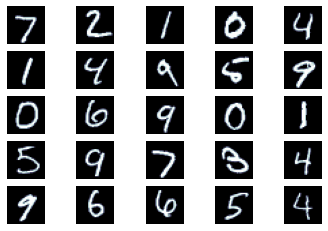

In [42]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

Classes = list(range(10))
# Classes = [0,1]
train_data = [(x,y) for x,y in train_data if y in Classes]
test_data = [(x,y) for x,y in test_data if y in Classes]

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

N_IMAGES = 25

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

D_IN = 28*28

plot_images(images)

In [14]:
import torchvision
trainset = torchvision.datasets.CIFAR100(root='.data',train=True,download=True)
testset = torchvision.datasets.CIFAR100(root='.data',train=False,download=True)

train_data = [(np.array(x,np.float32),np.float32(y)) for x,y in trainset]
test_data = [(np.array(x,np.float32),np.float32(y)) for x,y in testset]

num_classes = 100

D_IN = 32*32*3

Files already downloaded and verified
Files already downloaded and verified


In [22]:
import torchvision
trainset = torchvision.datasets.CIFAR10(root='.data',train=True,download=True)
testset = torchvision.datasets.CIFAR10(root='.data',train=False,download=True)

train_data = [(np.array(x,np.float32),np.float32(y)) for x,y in trainset]
test_data = [(np.array(x,np.float32),np.float32(y)) for x,y in testset]

num_classes = 10

D_IN = 32*32*3

Files already downloaded and verified
Files already downloaded and verified


In [23]:
X = train_data[0][0]
N = len(X.flatten())
Ind = np.array(np.unravel_index(range(N),shape=X.shape))
def get_X2(X):
    X2 = np.zeros((4,N))
    X2[:3,:] = Ind
    X2[3,:] = X.flatten()
    return np.array(X2.flatten(),np.float32)
train_data = [(get_X2(x),y) for x,y in train_data]
test_data = [(get_X2(x),y) for x,y in test_data]

D_IN = len(train_data[0][0].flatten())